In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

##  make dataset

In [2]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
TRAIN_SIZE = 30000
EVAL_SIZE = 2000

def make_mnist_data():
    from keras.datasets import mnist
    # load MNIST data
    (X_train, y_train), (X_eval, y_eval) = mnist.load_data()
    X_train = X_train.astype('float32')
    X_train = X_train[:TRAIN_SIZE]
    y_train = y_train[:TRAIN_SIZE]
    X_eval = X_eval.astype('float32')
    X_eval = X_eval[:EVAL_SIZE]
    y_eval = y_eval[:EVAL_SIZE]
    print('train shape: ', X_train.shape, y_train.shape)
    print('eval shape: ', X_eval.shape, y_eval.shape)
    # scale samples from 0 to 1
    X_train /= 255
    X_eval /= 255
    # scale from -1 to 1
    X_train = 2 * X_train - 1
    X_eval = 2 * X_eval - 1
    return X_train, y_train, X_eval, y_eval

train shape:  (30000, 28, 28) (30000,)
eval shape:  (2000, 28, 28) (2000,)


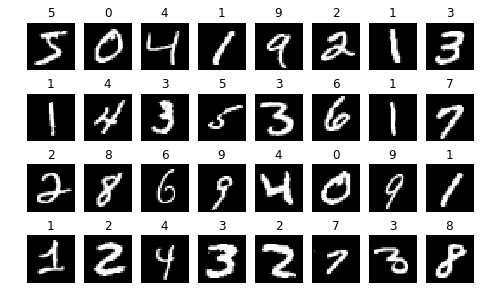

In [4]:
def mnist_plot(X, y):
    plt.figure(figsize=(8, 5))
    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.axis('off')
        plt.imshow(X[i], cmap='gray')
        plt.title(y[i])
    plt.show()

X_train, y_train, X_eval, y_eval = make_mnist_data()
mnist_plot(X_train, y_train)

## build RCGAN model

In [5]:
def DPSGD(sigma, l2norm_bound, learning_rate, total_examples):
    import tensorflow as tf
    from differential_privacy.dp_sgd.dp_optimizer import dp_optimizer
    from differential_privacy.dp_sgd.dp_optimizer import sanitizer
    from differential_privacy.privacy_accountant.tf import accountant

    eps = tf.placeholder(tf.float32)
    delta = tf.placeholder(tf.float32)

    priv_accountant = accountant.GaussianMomentsAccountant(total_examples)
    clip = True
    batches_per_lot = 1

    gaussian_sanitizer = sanitizer.AmortizedGaussianSanitizer(
                    priv_accountant,
                    [l2norm_bound, clip])

    return dp_optimizer.DPGradientDescentOptimizer(learning_rate,
                                                  [eps, delta],
                                                  sanitizer=gaussian_sanitizer,
                                                  sigma=sigma,
                                                  batches_per_lot=batches_per_lot)

In [6]:
class RCGAN():
    def __init__(self,
                 input_dim,
                 seq_length,
                 latent_dim,
                 hidden_dim,
                 embed_dim,
                 batch_size,
                 num_classes,
                 summary=False,
                 save_image=False,
                 save_model=False,
                 make_data=False):

        self.input_dim = input_dim
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.save_image = save_image
        self.save_model = save_model
        self.make_data = make_data

        # model instantiation
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()
        
        # define input tenor shape
        # we define batch size here for DP-SGD
        x = Input(batch_shape=(self.batch_size, self.seq_length, self.input_dim))
        z = Input(batch_shape=(self.batch_size, self.seq_length, self.latent_dim))
        c = Input(batch_shape=(self.batch_size, 1), dtype='int32')
        
        self.set_trainable(self.generator, trainable=False)
        
        # discriminator takes real x and gererated gx
        d_logit_real = self.discriminator([x, c])
        gx = self.generator([z, c])
        d_logit_fake = self.discriminator([gx, c])
        
        # get loss function
        d_loss, g_loss = self.gan_loss(d_logit_real, d_logit_fake)
        
        # build traiable discriminator model
        self.D_model = Model([x, z, c], [d_logit_real, d_logit_fake])
        self.D_model.add_loss(d_loss)
        self.D_model.compile(optimizer=D_OPTIMIZER, loss=None)
        
        # freeze discriminator parameter when training discriminator
        self.set_trainable(self.generator, trainable=True)
        self.set_trainable(self.discriminator, trainable=False)
        
        # build traiable generator model
        self.G_model = Model([z, c], d_logit_fake)
        self.G_model.add_loss(g_loss)
        self.G_model.compile(optimizer=G_OPTIMIZER, loss=None)
        
    def gan_loss(self, d_logit_real, d_logit_fake):
        """
        define loss function
        """
        
        d_loss_real = K.mean(K.binary_crossentropy(output=d_logit_real, 
                                                   target=K.ones_like(d_logit_real), 
                                                   from_logits=True), axis=1)
        d_loss_fake = K.mean(K.binary_crossentropy(output=d_logit_fake, 
                                                   target=K.zeros_like(d_logit_fake), 
                                                   from_logits=True), axis=1)
        
        d_loss = K.mean(d_loss_real + d_loss_fake)
        
        g_loss = K.mean(K.binary_crossentropy(output=d_logit_fake, 
                                              target=K.ones_like(d_logit_fake), 
                                              from_logits=True))
        
        return d_loss, g_loss
        

    def build_generator(self):

        # define sequential model
        model = Sequential()

        model.add(CuDNNLSTM(units=self.hidden_dim, 
                       return_sequences=True))
        model.add(TimeDistributed(Dense(self.input_dim, activation='tanh')))

        # define tenor variable
        z = Input(batch_shape=(self.batch_size, self.seq_length, self.latent_dim))
        c = Input(batch_shape=(self.batch_size, 1), dtype='int32')
        c_emb = Flatten()(Embedding(self.num_classes, self.embed_dim)(c))
        c_emb = RepeatVector(self.seq_length)(c_emb)
#         inputs = multiply([z, c_emb])
        inputs = concatenate([z, c_emb], axis=-1)

        # define generator output
        gx = model(inputs)

        return Model([z, c], gx)

    def build_discriminator(self):

        # define sequential model
        model = Sequential()

        model.add(CuDNNLSTM(units=self.hidden_dim, 
                       return_sequences=True))
#         model.add(TimeDistributed(Dense(1, activation='sigmoid')))  pass logit value to loss function
        model.add(TimeDistributed(Dense(1)))

        # define tenor variable 
        x = Input(batch_shape=(self.batch_size, self.seq_length, self.input_dim))
        c = Input(batch_shape=(self.batch_size, 1), dtype='int32')
        c_emb = Flatten()(Embedding(self.num_classes, self.embed_dim)(c))
        c_emb = RepeatVector(self.seq_length)(c_emb)
        
#         inputs = multiply([x, c_emb])
        inputs = concatenate([x, c_emb], axis=-1)
    
        # define discriminator output
        validity = model(inputs)

        return Model([x, c], validity)

    def set_trainable(self, model, trainable=False):
        model.trainable = trainable
        for layer in model.layers:
            layer.trainable = trainable
        
    def data_shuffle(self, x, y):
        # shuffle x and y 
        rnd = np.random.randint(999)
        for l in [x, y]:
            np.random.seed(rnd)
            np.random.shuffle(l)

    def train(self, n_epochs, X_train, y_train):

        for epoch in range(n_epochs):

            self.data_shuffle(X_train, y_train)

            for i in range(0, int(X_train.shape[0] / self.batch_size)):
                
                tr_x = X_train[i * self.batch_size: (i + 1) * self.batch_size]
                tr_y = y_train[i * self.batch_size: (i + 1) * self.batch_size]

                noise = np.random.normal(0, 1, (
                    self.batch_size, self.seq_length, self.latent_dim))

                d_loss_curr = self.D_model.train_on_batch([tr_x, noise, tr_y], None)
                g_loss_curr = self.G_model.train_on_batch([noise, tr_y], None)
            
            if (epoch + 1)% 5 == 0:
                # Plot the progress
                print ("epoch {} [D loss: {:.3f}] [G loss: {:.3f}]".format(epoch + 1,
                                                                           np.mean(d_loss_curr),
                                                                           np.mean(g_loss_curr)))
                # Plot gererated samples from cureent generator
                noise = np.random.normal(0, 1, (
                    self.batch_size, self.seq_length, self.latent_dim))
                sample_c = np.random.randint(0, self.num_classes, self.batch_size)
                sample_gx = self.generator.predict([noise, sample_c])
                mnist_plot(sample_gx, sample_c)

## set hyper parameter

In [7]:
from keras.layers import Input, Dense, Reshape, CuDNNLSTM
from keras.layers import concatenate, Flatten, Embedding, RepeatVector
from keras.layers.recurrent import LSTM
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.layers.wrappers import TimeDistributed
from keras import backend as K

In [8]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# set_session(sess)

In [9]:
# hyper parameter for training
input_dim = X_train.shape[2]
seq_length = X_train.shape[1]
latent_dim = 50
hidden_dim = 100
embed_dim = 10
batch_size = 32
n_epochs = 50
num_classes = 10

sigma = 1e-01
l2norm_bound = 1e-01
learning_rate = 0.1
total_examples = X_train.shape[0]

# set optimizer
# D_OPTIMIZER = DPSGD(sigma, l2norm_bound, learning_rate, total_examples)
D_OPTIMIZER = SGD(learning_rate)
G_OPTIMIZER = Adam()

rcgan = RCGAN(input_dim,
              seq_length,
              latent_dim,
              hidden_dim,
              embed_dim,
              batch_size,
              num_classes)

## train iteration

epoch 5 [D loss: 0.257] [G loss: 5.756]


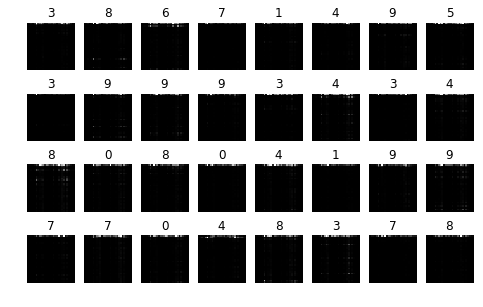

epoch 10 [D loss: 1.052] [G loss: 1.792]


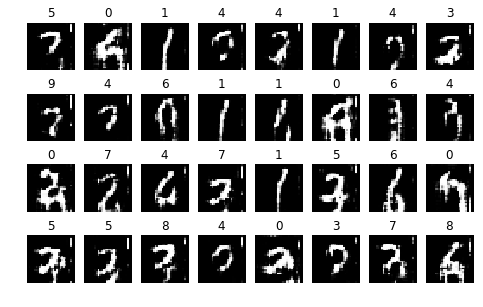

epoch 15 [D loss: 1.030] [G loss: 1.664]


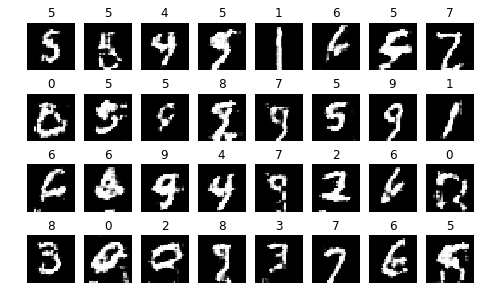

epoch 20 [D loss: 1.071] [G loss: 1.171]


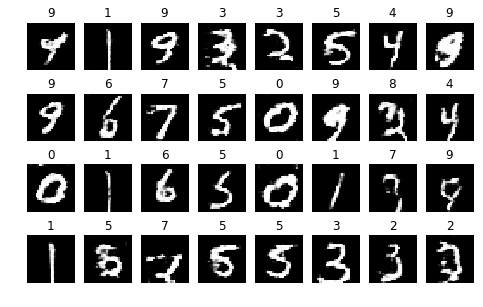

epoch 25 [D loss: 1.228] [G loss: 0.867]


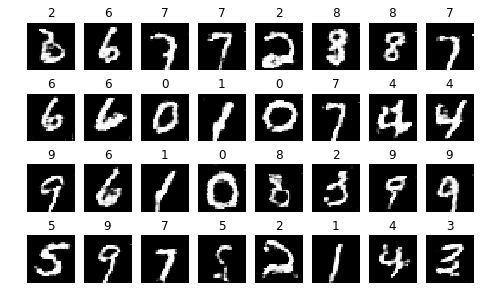

epoch 30 [D loss: 1.221] [G loss: 0.913]


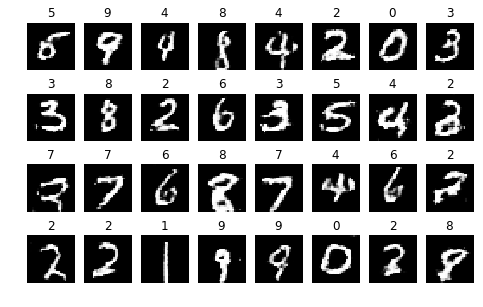

epoch 35 [D loss: 1.370] [G loss: 0.609]


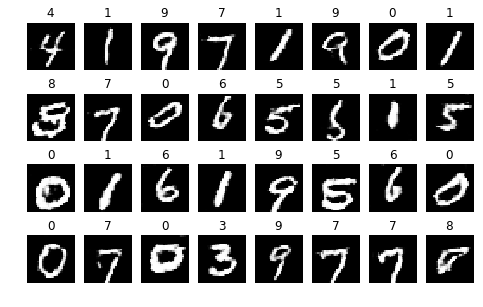

epoch 40 [D loss: 1.338] [G loss: 0.573]


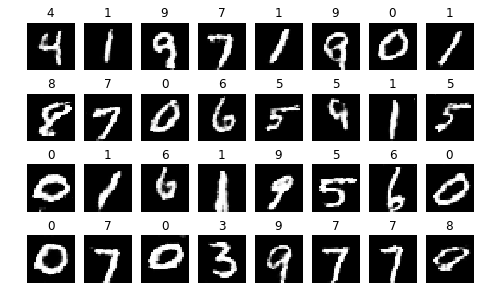

epoch 45 [D loss: 1.099] [G loss: 1.131]


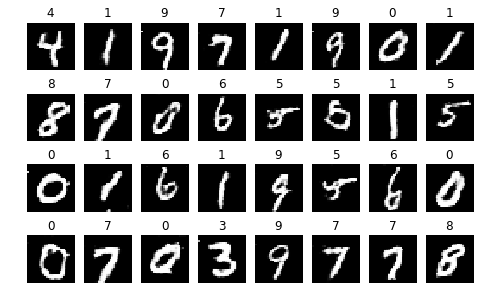

epoch 50 [D loss: 1.170] [G loss: 1.058]


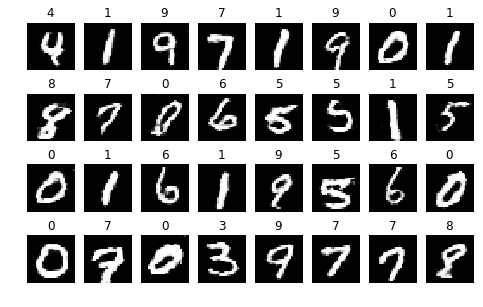

In [10]:
rcgan.train(n_epochs, X_train, y_train)

## reconstruction

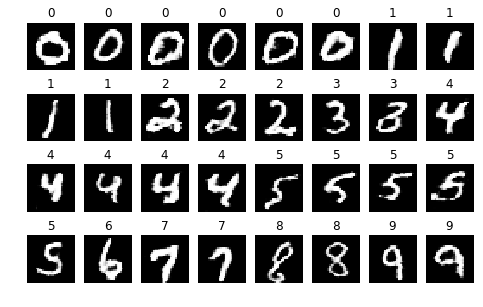

In [13]:
noise = np.random.normal(0, 1, (batch_size, seq_length, latent_dim))
sample_c = np.sort(np.random.randint(0, num_classes, batch_size))
sample_gx = rcgan.generator.predict([noise, sample_c])
mnist_plot(sample_gx, sample_c)